# State Distribution Example

In this example, we plan to plot the distribution of system states. This helps researchers on serverless computing platforms to debug and test out their performance models with knowledge of system state distribution.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from simfaas.ServerlessSimulator import ServerlessSimulator as Sim

sim = Sim(arrival_rate=0.9, warm_service_rate=1/1.991, cold_service_rate=1/2.244,
            expiration_threshold=600, max_time=1e6)
sim.generate_trace(debug_print=False, progress=True)
sim.print_trace_results()

100%|██████████| 1000000/1000000 [00:42<00:00, 23410.45it/s]
Cold Starts / total requests: 	 1213 / 898469
Cold Start Probability: 	 0.0014
Rejection / total requests: 	 0 / 898469
Rejection Probability: 		 0.0000
Average Instance Life Span: 	 6335.1337
Average Server Count:  		 7.6612
Average Running Count:  	 1.7879
Average Idle Count:  		 5.8733


You can define any state representation you want based on the data present in the trace.
Here, we chose to use the number of servers as state.

In [3]:
sim.calculate_time_lengths()
skip_init = sim.get_skip_init(skip_init_time=100)

# encode states
hist_states = []
for idx in range(len(sim.hist_server_count)):
    if sim.hist_server_count[idx] == 0:
        hist_states.append((0, 'd'))
    else:
        curr_server_count = sim.hist_server_count[idx]
        prev_server_count = sim.hist_server_count[idx-1]
        if curr_server_count > prev_server_count:
            hist_states.append((curr_server_count, 'u'))
        elif curr_server_count < prev_server_count:
            hist_states.append((curr_server_count, 'd'))
        else: # state hasn't changed
            hist_states.append(hist_states[-1])

vals, probs = sim.calculate_time_average(hist_states, skip_init_index=skip_init)
sim.print_time_average(vals, probs)
residence_time_avgs = sim.get_average_residence_times(hist_states, skip_init_index=skip_init)
residence_time_list = [residence_time_avgs[s] for s in vals]
df = pd.DataFrame(data = {'state': vals, 'prob': probs, 'sojourn_time': residence_time_list})
df = df.sort_values(by='state')
df

Value           Prob
(10, 'd')       0.0009
(6, 'd')        0.0670
(8, 'u')        0.2866
(11, 'd')       0.0000
(9, 'd')        0.0009
(9, 'u')        0.1285
(11, 'u')       0.0048
(8, 'd')        0.0477
(6, 'u')        0.0000
(10, 'u')       0.0328
(12, 'u')       0.0030
(7, 'd')        0.2880
(7, 'u')        0.1397
(5, 'd')        0.0001


,state,prob,sojourn_time
13,"(5, d)",0.000087,43.521367
1,"(6, d)",0.066961,217.382787
8,"(6, u)",0.000048,24.238230
11,"(7, d)",0.287959,513.243644
12,"(7, u)",0.139723,453.600191
7,"(8, d)",0.047746,190.205522
2,"(8, u)",0.286558,510.395082
4,"(9, d)",0.000876,13.470193
5,"(9, u)",0.128473,511.792385
0,"(10, d)",0.000932,71.706597


## Calculate Average Transition Times

In [4]:
residence_times, transition_times = sim.analyze_custom_states(hist_states, skip_init_index=skip_init)
transition_counts = {}
for k in transition_times:
    transition_counts[k] = len(transition_times[k])

t_starts = [s[0] for s in transition_counts.keys()]
t_ends = [s[1] for s in transition_counts.keys()]
t_counts = [transition_counts[k] for k in transition_counts.keys()]
t_avgs = [np.mean(transition_times[s]) for s in transition_counts.keys()]

df = pd.DataFrame(data = {'start': t_starts, 'end': t_ends, 'count': t_counts, 'average': t_avgs})

t_totals = [df.loc[df['start'] == k[0], 'count'].sum() for k in transition_counts.keys()]
df['totals'] = t_totals
df['prob'] = df['count'] / df['totals']

df = df.sort_values(by='start')
df

,start,end,count,average,totals,prob
21,"(5, d)","(6, u)",2,43.521367,2,1.000000
20,"(6, d)","(5, d)",2,1.204540,308,0.006494
9,"(6, d)","(7, u)",306,218.795716,308,0.993506
22,"(6, u)","(7, u)",2,24.238230,2,1.000000
1,"(7, d)","(8, u)",305,582.772978,561,0.543672
8,"(7, d)","(6, d)",256,430.405959,561,0.456328
10,"(7, u)","(6, d)",52,917.175900,308,0.168831
11,"(7, u)","(8, u)",256,359.436375,308,0.831169
4,"(8, d)","(7, d)",228,182.310806,251,0.908367
17,"(8, d)","(9, u)",23,268.466185,251,0.091633


## Calculate Transition Time Histograms

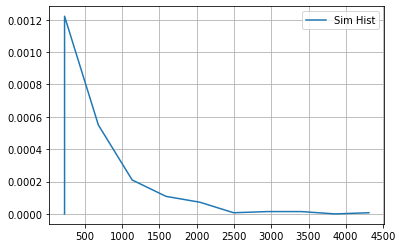

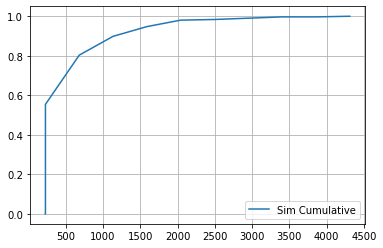

In [5]:
from simfaas.Utility import convert_hist_pdf

transition = ((7, 'd'),(8, 'u'))
traces = transition_times[transition]
num_bins = 10
base, hist_values, cumulative = convert_hist_pdf(traces, num_bins)

plt.figure()
plt.plot(base, hist_values, label='Sim Hist')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(base, cumulative, label='Sim Cumulative')
plt.legend()
plt.grid(True)

## Calculate Cold Start Probabily per State

In this section, we want to calculate the probability of a cold start occuring for a given state. This gives us a lot of insight about how to debug our performance model.

In [6]:
reqdf = sim.get_request_custom_states(hist_states=hist_states, skip_init_index=skip_init)
reqdf = reqdf.sort_values(by='state')
reqdf

,state,cold,warm,rej,total,p_cold
12,"(5, d)",2,81,0,83,0.024096
6,"(6, d)",306,60079,0,60385,0.005067
13,"(6, u)",2,53,0,55,0.036364
1,"(7, d)",305,258005,0,258310,0.001181
7,"(7, u)",256,124675,0,124931,0.002049
3,"(8, d)",23,43038,0,43061,0.000534
0,"(8, u)",228,257671,0,257899,0.000884
5,"(9, d)",1,731,0,732,0.001366
2,"(9, u)",64,115767,0,115831,0.000553
11,"(10, d)",0,849,0,849,0.000000


## Calculate Time Average of Server Count

Value           Prob
5               0.0001
6               0.0670
7               0.4277
8               0.3343
9               0.1293
10              0.0338
11              0.0048
12              0.0030


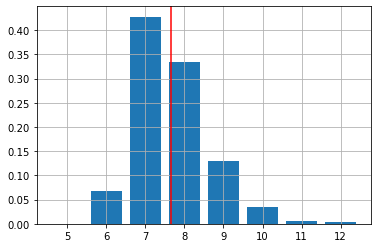

In [7]:
sim.calculate_time_lengths()

unq_vals, val_times = sim.calculate_time_average(sim.hist_server_count, skip_init_time=100)

plt.bar(unq_vals, val_times)
plt.grid(True)
plt.axvline(x=sim.get_average_server_count(), c='r')

sim.print_time_average(unq_vals, val_times)

In [8]:
pd.DataFrame(data = {'server_count': unq_vals, 'Probability': val_times}).sort_values('server_count')

,server_count,Probability
0,5,0.000087
1,6,0.067009
2,7,0.427682
3,8,0.334304
4,9,0.129349
5,10,0.033755
6,11,0.004812
7,12,0.003002
